# 4. Data analysis – tree coverage and population distribution

Now that we have computed all the information we need on Earth Engine, we can start further analyzing it locally.

Apart from the total tree covered area in each city, one important aspect is to get how many people live in areas with good and bad tree cover. Some cities have significant green areas, but they are in unpopulated places – either richer, low-density neighborhoods or forested swathes of land on the periphery.

In [1]:
# Importing packages
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## 4.1 Loading relevant data

In [2]:
# Original city information
cities = gpd.read_file("../input/GHS_STAT_UCDB2015MT_GLOBE_R2019A/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg")
# Keeps only identifier columns
cities = cities[["ID_HDC_G0", "CTR_MN_NM", "UC_NM_MN", "CTR_MN_ISO", "UC_NM_LST", # Names and identifiers
                 "INCM_CMI", "DEV_CMI", # Income and development markers
                 "E_BM_NM_LST", "E_KG_NM_LST",   # Biomes and climates
                ]]

In [3]:
# Extra information on continent, region and subregion
info = pd.read_csv("../input/country_classifications/country-and-continent-codes-list.csv", sep=';')
# Keeps only useful identifier columns
info = info[['ISO-alpha3 code', 'continent', 'region', 'subregion']]

In [4]:
# Original hexbin shapefiles
hex_shp = gpd.read_file("../output/city_hexagons/city_hexagons.shp")

In [5]:
# Hexbins with computed data
hex_data = pd.read_csv("../output/earth_engine_exports/TreeCoverAnalysis-Hexagons-27-08-24-08_32.csv")

In [6]:
# Joins shapes, data and city information
hexbins = hex_data.merge(hex_shp, on=['city_id', 'hexagon_n'])\
        .merge(cities, left_on='city_id', right_on='ID_HDC_G0')\
        .merge(info, left_on='CTR_MN_ISO', right_on='ISO-alpha3 code')

In [7]:
# Makes it, again, into a geodataframe
hexbins = gpd.GeoDataFrame(hexbins)

In [8]:
hexbins.head()

,city_id,hexagon_n,lon,lat,tree_area,ft_area,tree_pct,pop_ft,area,geometry,...,CTR_MN_ISO,UC_NM_LST,INCM_CMI,DEV_CMI,E_BM_NM_LST,E_KG_NM_LST,ISO-alpha3 code,continent,region,subregion
0,1452.0,0,-17.501080,14.754880,775.859839,723483.501045,0.001072,2752.569644,0.723621,"POLYGON ((-17.50113 14.75950, -17.49674 14.757...",...,SEN,Dakar; Guédiawaye; Parcelles Assainies; Rufisq...,LIC,LDCL,"Tropical and subtropical grasslands, savannas,...","Steppe (semi-arid), and Hot arid",SEN,Africa,Sub-Saharan Africa,Western Africa
1,1452.0,1,-17.422321,14.744907,3424.605559,722867.374470,0.004738,13226.590721,0.723114,"POLYGON ((-17.42237 14.74952, -17.41798 14.747...",...,SEN,Dakar; Guédiawaye; Parcelles Assainies; Rufisq...,LIC,LDCL,"Tropical and subtropical grasslands, savannas,...","Steppe (semi-arid), and Hot arid",SEN,Africa,Sub-Saharan Africa,Western Africa
2,1452.0,2,-17.465827,14.728914,12.499531,723063.880962,0.000017,15852.254603,0.723099,"POLYGON ((-17.46588 14.73353, -17.46149 14.731...",...,SEN,Dakar; Guédiawaye; Parcelles Assainies; Rufisq...,LIC,LDCL,"Tropical and subtropical grasslands, savannas,...","Steppe (semi-arid), and Hot arid",SEN,Africa,Sub-Saharan Africa,Western Africa
3,1452.0,3,-17.339451,14.755890,144167.964578,722790.313681,0.199460,2505.278298,0.722871,"POLYGON ((-17.33950 14.76050, -17.33511 14.758...",...,SEN,Dakar; Guédiawaye; Parcelles Assainies; Rufisq...,LIC,LDCL,"Tropical and subtropical grasslands, savannas,...","Steppe (semi-arid), and Hot arid",SEN,Africa,Sub-Saharan Africa,Western Africa
4,1452.0,4,-17.422019,14.717225,0.000000,722465.937096,0.000000,0.000000,0.722732,"POLYGON ((-17.42207 14.72184, -17.41768 14.719...",...,SEN,Dakar; Guédiawaye; Parcelles Assainies; Rufisq...,LIC,LDCL,"Tropical and subtropical grasslands, savannas,...","Steppe (semi-arid), and Hot arid",SEN,Africa,Sub-Saharan Africa,Western Africa


## 4.2 Population distribution in different tree cover areas

In [9]:
# Puts each one of the hexbins in a larger bucket: for example,
# hexagons with a 28% tree coverage will fall in the bucker (25% – 30%),
# if the step is step up to 0.05
step = .02
start, end = 0, 1 + step
bin_edges = np.arange(start, end, step)
hexbins['tr_pct_bin'] = pd.cut(hexbins['tree_pct'], 
                                      bins=bin_edges, include_lowest=True, right=False)

In [10]:
# A function to compute the share of population living in each one of the tree coverage levels computed above
def compute_pop_distribution(hexbins):
    '''
    For each city, computes how many people are living in
    hexagons with different levels of tree coverage.

    Parameters:
    hexbins (geopandas.GeoDataFrame): the geodataframe containing all the hexbins

    Returns:
    pd.DataFrame: a DataFrame showing the percentage and total people living at each tree coverage level,
    for each city.
    '''
    
    # Groupby on city identifiers and bin size, then sum total population. 
    group_columns = ['city_id', 'tr_pct_bin']
    distributions = hexbins.groupby(group_columns)['pop_ft'].sum().reset_index()
    
    # The total population of the hexagons in city, transformed
    # in a way that it can directly divide the population of the hexagon.
    city_populations = distributions.groupby('city_id').pop_ft.transform('sum')
    
    # Computes the percentage for the distributions
    distributions['pop_ft_pct'] = distributions.pop_ft / city_populations
    
    # Keeps the extra information columns on hexbins
    # drop duplicates and merge them back into the dataframe.
    # This is quicker than grouping on all columns.
    info = hexbins.drop_duplicates(subset=['city_id', 'tr_pct_bin'])
    info = info[['city_id', 'tr_pct_bin', 'UC_NM_MN', 'CTR_MN_NM', 'CTR_MN_ISO', 'continent', 'INCM_CMI']]
    distributions = distributions.merge(info, on=['city_id', 'tr_pct_bin'])
    
    return distributions


In [11]:
# Now, for each city, we have the distribution of the population living in each tree coverage area.
# Let's save that so we can access later, when getting representative images of each city.
pop_distribution = compute_pop_distribution(hexbins)
pop_distribution.to_csv("../output/population-by-tree-coverage-bin.csv", index=False)
pop_distribution.head()

,city_id,tr_pct_bin,pop_ft,pop_ft_pct,UC_NM_MN,CTR_MN_NM,CTR_MN_ISO,continent,INCM_CMI
0,10.0,"[0.0, 0.02)",535863.397407,0.113691,San Jose,United States,USA,Americas,HIC
1,10.0,"[0.02, 0.04)",696202.730230,0.147709,San Jose,United States,USA,Americas,HIC
2,10.0,"[0.04, 0.06)",757926.919928,0.160805,San Jose,United States,USA,Americas,HIC
3,10.0,"[0.06, 0.08)",617455.151767,0.131002,San Jose,United States,USA,Americas,HIC
4,10.0,"[0.08, 0.1)",467465.030952,0.099179,San Jose,United States,USA,Americas,HIC


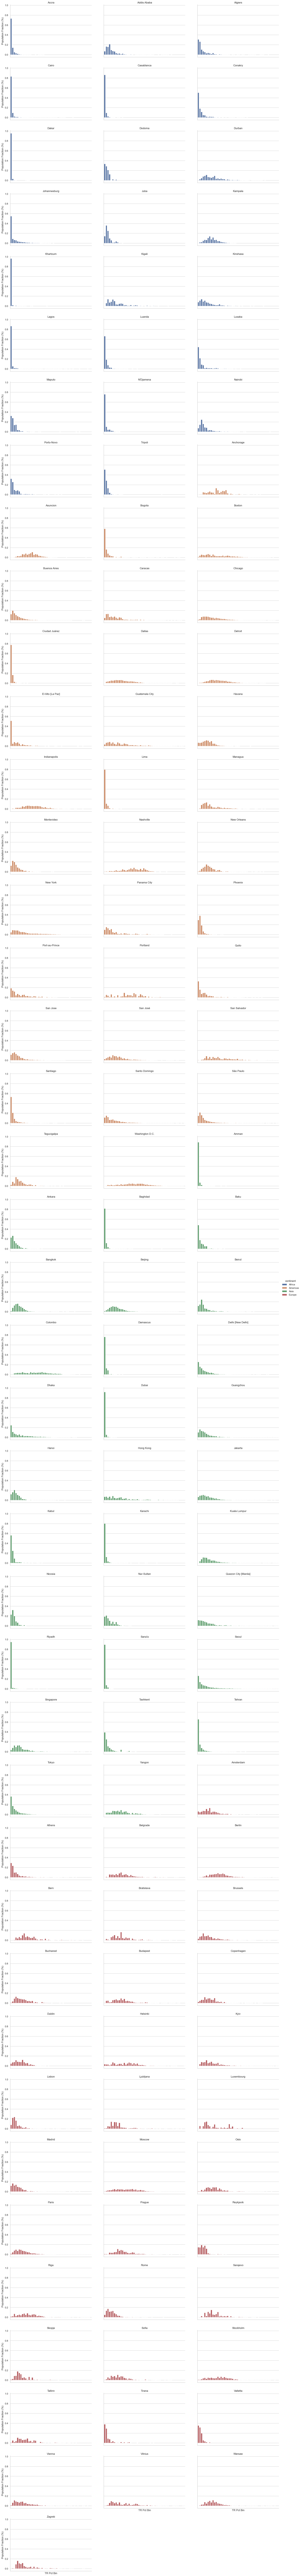

In [12]:
# Let's quickly visualize that, making histogram-like shapes that show the 
# concentration of population living in each bucket for each city.
# The code in this cell was written with the help of Chat GPT 4o.

# Set the seaborn style
sns.set(style="whitegrid")

# Create the small multiples (one for each city)
g = sns.FacetGrid(pop_distribution.sort_values(by=['continent', 'UC_NM_MN']),
                  col="UC_NM_MN", hue="continent", col_wrap=3, height=4, aspect=1.5)

# Map the barplot to the grid
g.map(sns.barplot, "tr_pct_bin", "pop_ft_pct", order=sorted(pop_distribution['tr_pct_bin'].unique()))

# Add a legend and adjust the layout
g.add_legend()
g.set_axis_labels("TR Pct Bin", "Population Fraction (%)")
g.set_titles("{col_name}")

for ax in g.axes.flatten():
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
# Show the plot
plt.show()

## 4.3 Visualizing hexagon maps

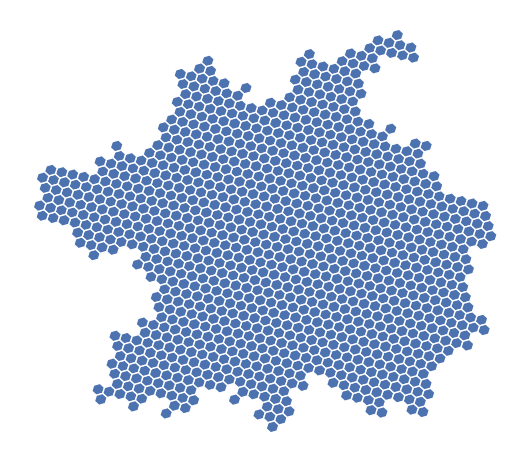

In [13]:
# We can also quickly visuaslize any given city as map made of its hexagons.
# For example, this is all the hexagons that make up Berlin:
ax = hexbins[hexbins.UC_NM_MN=='Berlin'].plot()
ax.axis('off')
plt.tight_layout()

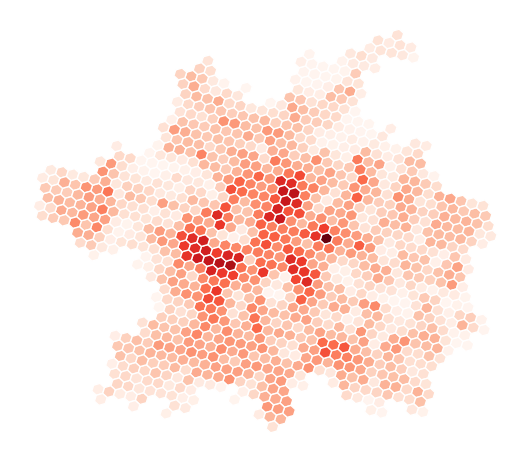

In [14]:
# We can show the population density
ax = hexbins[hexbins.UC_NM_MN=='Berlin'].plot(column='pop_ft', cmap='Reds')
ax.axis('off')
plt.tight_layout()

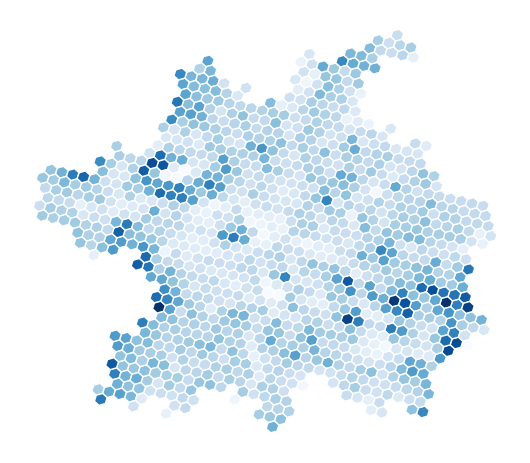

In [15]:
# And the tree density
ax = hexbins[hexbins.UC_NM_MN=='Berlin'].plot(column='tree_pct', cmap='Blues')
ax.axis('off')
plt.tight_layout()

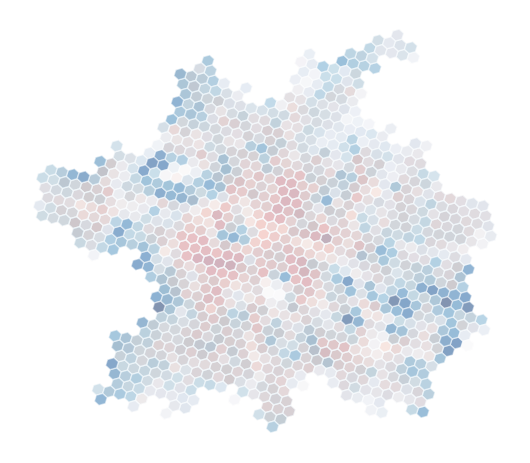

In [16]:
# And we can lay one over the other, highlighting places
# that have at the same time lots of trees and lots of people.
# Those are the dark gray areas.
ax = hexbins[hexbins.UC_NM_MN=='Berlin'].plot(column='pop_ft', cmap='Reds', alpha=.5)
hexbins[hexbins.UC_NM_MN=='Berlin'].plot(column='tree_pct', cmap='Blues', alpha=.5, ax=ax)
ax.axis('off')
plt.tight_layout()


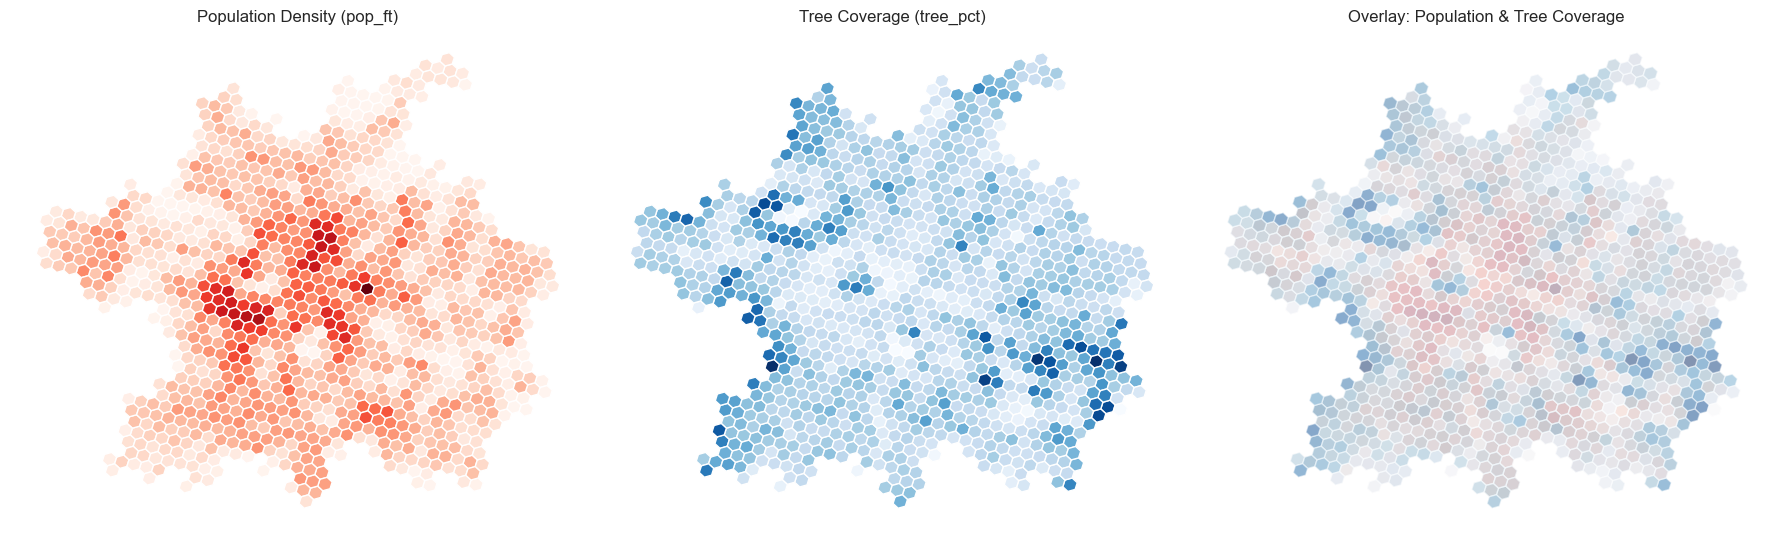

In [17]:
# Let's plot them side by side
# Filter the data for Berlin
berlin_data = hexbins[hexbins.UC_NM_MN == 'Berlin']

# Create subplots: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: pop_ft
berlin_data.plot(column='pop_ft', cmap='Reds', alpha=1, ax=axs[0])
axs[0].set_title('Population Density (pop_ft)')
axs[0].axis('off')  # Hide the axes

# Second subplot: tree_pct
berlin_data.plot(column='tree_pct', cmap='Blues', alpha=1, ax=axs[1])
axs[1].set_title('Tree Coverage (tree_pct)')
axs[1].axis('off')  # Hide the axes

# Third subplot: overlay of pop_ft and tree_pct
ax = berlin_data.plot(column='pop_ft', cmap='Reds', alpha=0.5, ax=axs[2])
berlin_data.plot(column='tree_pct', cmap='Blues', alpha=0.5, ax=ax)
axs[2].set_title('Overlay: Population & Tree Coverage')
axs[2].axis('off')  # Hide the axes

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()